In [1]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from tensorflow import keras

import tensorflow as tf
import string
import re
import numpy as np

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.16.1

GPU is AVAILABLE


In [3]:
# Define the correct file path
file_path = "/kaggle/input/nlp-cleaned/english_swahili_sentence_pairs_cleaned.csv"

# Read the data
df = pd.read_csv(file_path)


In [4]:
df

,English sentence,Swahili Translation
0,I am.,Mimi ni.
1,Him.,Yeye.
2,Her.,Yeye.
3,You.,Wewe.
4,We.,Sisi.
...,...,...
198953,The national army safeguards the country's bor...,Jeshi la kitaifa linalinda mpaka wa nchi hiyo ...
198954,I participated in last year's motor rally cham...,Nilishiriki katika mashindano ya rally ya moto...
198955,This court mainly deals with crimes committed ...,Korti hii inashughulikia uhalifu uliofanywa na...
198956,The company terminated their contract yesterday.,Kampuni hiyo ilisitisha mkataba wao jana.


In [5]:

# Add 'source' and 'target' columns
df['source'] = df['English sentence']
df['target'] = df['Swahili Translation'].apply(lambda x: '[start] ' + x + ' [end]')

# Drop unnecessary columns
df = df.drop(['English sentence', 'Swahili Translation'], axis=1)

# Display a few random samples
print(df.sample(5))

                                           source  \
16219  This is years since his valve replacement.   
69321                           He meant no harm.   
53267                          Bulgaria road map.   
73672                          Tom works at home.   
92821                    Do you think i'm stupid?   

                                                  target  
16219  [start] Hii ni miaka tangu uingizwaji wake wa ...  
69321            [start] Alimaanisha hakuna ubaya. [end]  
53267      [start] Ramani ya barabara ya bulgaria. [end]  
73672          [start] Tom anafanya kazi nyumbani. [end]  
92821            [start] Unafikiri mimi ni mjinga? [end]  


In [6]:
df.head()

,source,target
0,I am.,[start] Mimi ni. [end]
1,Him.,[start] Yeye. [end]
2,Her.,[start] Yeye. [end]
3,You.,[start] Wewe. [end]
4,We.,[start] Sisi. [end]


SPLITTING

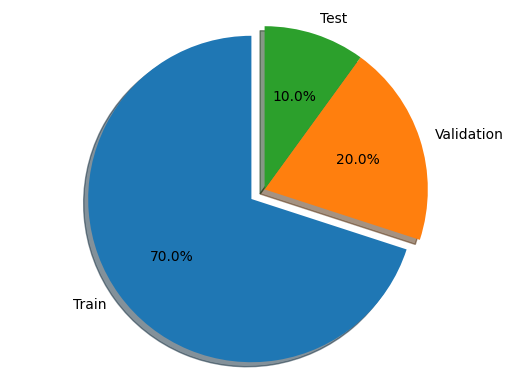

In [7]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# split the data into train, validation, and test sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.1)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# display the data sets representations using a pie chart just to see the distribution of the data
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(val_df), len(test_df)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


# tokenizing

In [8]:
max_tokens = 25000
sequence_length = 30

# define a custom standardization function that convert to lowercase and strips all punctuations except "[" and "]" (so we can tell apart "start" from "[start]").
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
 
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# tokenize the data using our custom standardization function
source_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)

# index all tokens in the source and target sentences
train_source_texts = train_df['source'].values
train_target_texts = train_df['target'].values
source_vectorization.adapt(train_source_texts)
target_vectorization.adapt(train_target_texts)

In [9]:
# display a random sample before and after vectorization just to test the vectorization
random_sample = random.randint(0, len(train_df))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))

# display the decoding of the vectorized text (from vector back to text) just to test the vectorization
source_decoded_text = ''
for i in range(len(source_vectorization(train_source_texts[random_sample]))):
    source_decoded_text += source_vectorization.get_vocabulary()[source_vectorization(train_source_texts[random_sample])[i]] + ' '
print("Source decoded texts (one random sample):", source_decoded_text)

target_decoded_text = ''
for i in range(len(target_vectorization(train_target_texts[random_sample]))):
    target_decoded_text += target_vectorization.get_vocabulary()[target_vectorization(train_target_texts[random_sample])[i]] + ' '
print("Target decoded texts (one random sample):", target_decoded_text)

Source texts (one random sample): I often get a letter from him.
Target texts (one random sample): [start] Mara nyingi mimi hupokea barua kutoka kwake. [end]
Source vectors (one random sample): tf.Tensor(
[  5 282  88   6 485  34  43   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[   2   46   69   48 7261  273   36  219    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(31,), dtype=int64)
Source decoded texts (one random sample): i often get a letter from him                        
Target decoded texts (one random sample): [start] mara nyingi mimi hupokea barua kutoka kwake [end]                       


In [10]:
# display the shape of our vectorized data
train_source_vectors = source_vectorization(train_source_texts)
train_target_vectors = target_vectorization(train_target_texts)
print("Source vectors (shape):", train_source_vectors.shape)
print("Target vectors (shape):", train_target_vectors.shape)

Source vectors (shape): (139270, 30)
Target vectors (shape): (139270, 31)


# Positional Embedding

In [11]:
class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim) # token embedding layer
        self.position_embeddings = keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # position embedding layer
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs) # embed the tokens
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) # embed the positions 
        return embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings

    def compute_mask(self, inputs, mask=None):
        return keras.ops.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

In [12]:
# display a random sample before and after embbeding just to test our class

embed_dim = 256

with tf.device('cpu:0'):
    train_source_embedded = PositionalEmbedding(
        sequence_length=sequence_length,
        input_dim=max_tokens,
        output_dim=embed_dim,
        name="source_embedding",
    ) (train_source_vectors)

    train_target_embedded = PositionalEmbedding(
        sequence_length=sequence_length,
        input_dim=max_tokens,
        output_dim=embed_dim,
        name="target_embedding",
    ) (train_source_vectors)

    random_sample = random.randint(0, len(train_df))
    print("Source texts (one random sample):", train_source_texts[random_sample])
    print("Target texts (one random sample):", train_target_texts[random_sample])
    print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
    print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))
    print("Source embedded vectors (one random sample):", train_source_embedded[random_sample])
    print("Target embedded vectors (one random sample):", train_target_embedded[random_sample])

Source texts (one random sample): Grasshoppers are seasonal insects.
Target texts (one random sample): [start] Grasshoppers ni wadudu wa msimu. [end]
Source vectors (one random sample): tf.Tensor(
[ 8174    18 11712  5769     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[    2 19091     8  3094     7   916     3     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0], shape=(31,), dtype=int64)
Source embedded vectors (one random sample): tf.Tensor(
[[-0.01866499  0.00616622 -0.05402397 ... -0.08396909 -0.03312936
   0.06532638]
 [ 0.04037527 -0.07929007 -0.01828209 ... -0.04480408  0.00403329
   0.04680081]
 [-0.05860395 -0.04521805 -0.08772665 ... -0.01408411  0.0130448
   0.00291384]
 ...
 [ 0.02281722  0.07147868

In [13]:
# display the shape of our embedded data just to test the class
print("Source embedded vectors (shape):", train_source_embedded.shape)
print("Target embedded vectors (shape):", train_target_embedded.shape)

Source embedded vectors (shape): (139270, 30, 256)
Target embedded vectors (shape): (139270, 30, 256)


# Attention 

In [14]:
# credits to OpenAI for that one (https://github.com/openai/gpt-2/blob/master/src/model.py)

def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w

In [15]:
# display the causal masking of a random tensor just to test the function
random_tensor = tf.random.uniform(shape=(1, 1, 5, 5), minval=0, maxval=1, dtype=tf.float32)
print("Masked attention weights:", mask_attn_weights(random_tensor))

Masked attention weights: tf.Tensor(
[[[[ 9.5843720e-01 -1.0000000e+10 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 3.3060622e-01  1.1689603e-01 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 2.8966928e-01  8.4028912e-01  9.9296749e-01 -1.0000000e+10
    -1.0000000e+10]
   [ 5.5471718e-01  8.4482193e-01  6.5454841e-02  1.6529107e-01
    -1.0000000e+10]
   [ 7.1845329e-01  2.6224947e-01  2.5937521e-01  2.3372722e-01
     1.8005729e-01]]]], shape=(1, 1, 5, 5), dtype=float32)


In [16]:
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    output = tf.matmul(weights, v) # Matmul of SoftMax and V
    return output

In [17]:
# display the shape of our attention output just to test the function
with tf.device('cpu:0'):
    input = train_source_embedded
    input = tf.expand_dims(input, axis=1)
    print("Scaled dot product attention (shape):", scaled_dot_product_attention(input, input, input, use_causal_mask=True).shape)

Scaled dot product attention (shape): (139270, 1, 30, 256)


**Multi-Head Attention**

In [18]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, embed_dim, h, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = keras.layers.Dense(embed_dim)
        self.k_linear = keras.layers.Dense(embed_dim)
        self.v_linear = keras.layers.Dense(embed_dim)
        self.concat_linear = keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        return concat

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

# The Encoder

In [19]:
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.global_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = keras.Sequential(
            [keras.layers.Dense(dense_dim, activation="relu"),
             keras.layers.Dense(embed_dim),]
        )
        
    def call(self, x):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

# The Decoder

In [20]:
class TransformerDecoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = keras.Sequential(
            [keras.layers.Dense(dense_dim, activation="relu"),
             keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.layer_norm_3 = keras.layers.LayerNormalization()

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

# THE TRANSFORMER

In [21]:
batch_size = 64

def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs, which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["source"].values, df["target"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)

In [22]:
# display the shape of the first batch of data in the dataset just to see what it looks like
for batch in train_ds.take(1):
    print("Encoder Inputs:", batch[0]["source"].shape)
    print("Decoder Inputs:", batch[0]["target"].shape)
    print("Decoder Outputs:", batch[1].shape)

Encoder Inputs: (64, 30)
Decoder Inputs: (64, 30)
Decoder Outputs: (64, 30)


In [23]:
embed_dim = 512 # dimension of the embedding space
dense_dim = 2048 # dimension of the feed forward network (a rule of thumb is to use 4 times the size of the embeddings)
num_heads = 8

# the transformer body
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="source")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="target")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

# the transformer head
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(max_tokens, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'transformer_encoder' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'transformer_decoder' (of type TransformerDecoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


# Training the Transformer

In [24]:
from tensorflow import keras


In [25]:
import tensorflow as tf
if not hasattr(tf.keras.backend, "convert_to_numpy"):
    tf.keras.backend.convert_to_numpy = lambda x: x.numpy() if hasattr(x, "numpy") else x


In [26]:
pip install --upgrade tensorflow


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.0 MB/s eta 0:00:00ta 0:00:01
^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [27]:
import tensorflow as tf
import keras

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)


TensorFlow Version: 2.16.1
Keras Version: 3.3.3


In [28]:
pip uninstall keras -y


Found existing installation: keras 3.3.3
Uninstalling keras-3.3.3:
  Successfully uninstalled keras-3.3.3
Note: you may need to restart the kernel to use updated packages.


# TRAINING

In [29]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

EPOCHS = 50
checkpoint_filepath = '/tmp/checkpoint.weights.h5'
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]
    
transformer.fit(train_ds, 
                epochs=EPOCHS, 
                callbacks=callbacks_list,
                validation_data=val_ds)

transformer.load_weights(checkpoint_filepath)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'multi_head_attention' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'multi_head_attention_1' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
I0000 00:00:1740349249.827100      88 service.cc:145] XLA service 0x7b7b88003260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740349249.827179      88 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:17403

   2/2177 ━━━━━━━━━━━━━━━━━━━━ 2:22 66ms/step - accuracy: 0.1704 - loss: 9.6350       

I0000 00:00:1740349256.360691      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1274/2177 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.7649 - loss: 1.9341

W0000 00:00:1740349325.642561      88 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2177/2177 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7792 - loss: 1.7578

W0000 00:00:1740349378.821622      87 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1740349381.343061      89 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2177/2177 ━━━━━━━━━━━━━━━━━━━━ 147s 62ms/step - accuracy: 0.7792 - loss: 1.7577 - val_accuracy: 0.8453 - val_loss: 1.0444 - learning_rate: 0.0010
Epoch 2/50
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 125s 57ms/step - accuracy: 0.8431 - loss: 1.0848 - val_accuracy: 0.8636 - val_loss: 0.8896 - learning_rate: 0.0010
Epoch 3/50
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 124s 57ms/step - accuracy: 0.8601 - loss: 0.9152 - val_accuracy: 0.8697 - val_loss: 0.8374 - learning_rate: 0.0010
Epoch 4/50
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 126s 58ms/step - accuracy: 0.8716 - loss: 0.8111 - val_accuracy: 0.8734 - val_loss: 0.8044 - learning_rate: 0.0010
Epoch 5/50
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 127s 58ms/step - accuracy: 0.8804 - loss: 0.7373 - val_accuracy: 0.8757 - val_loss: 0.8044 - learning_rate: 0.0010
Epoch 6/50
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 128s 59ms/step - accuracy: 0.8872 - loss: 0.6824 - val_accuracy: 0.8768 - val_loss: 0.8023 - learning_rate: 0.0010
Epoch 7/50
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 126s 58ms/step - accuracy: 

In [16]:
# # After training and loading the best weights:
# transformer.load_weights(checkpoint_filepath)

# # Save the entire model (architecture + weights + optimizer state)
# transformer.save("transformer_model")


In [31]:
# transformer.save("transformer_model.h5")


# Testing the Transformer

Let's translate a few random test sentences with our newly-trained Transformer.

In [33]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

# let's translate 50 random sentences
for i in range(50):
    random_index = np.random.randint(0, len(test_df))
    input_sentence = test_df["source"].iloc[random_index]
    print(input_sentence)
    print(decode_sequence(input_sentence))
    print()

Tom looked at the painting on the wall.
[start] tom alionekana uchoraji kwenye ukuta [end]

I have a black cat.
[start] nina paka mweusi [end]

How long have you been dating?
[start] umekuwa [UNK] kwa muda gani [end]

Tom isn't as fast as i am.
[start] tom hana haraka kama mimi [end]

Truly, you o muhammad saw are one of the messengers,.
[start] hakika wewe ni mmoja wao mitume [end]

The lights aren't on.
[start] taa ziko juu [end]

In this way we enter upon the path.
[start] kwa njia hii [UNK] kwenye njia [end]

All aboard!
[start] ndani yote [end]

Encourage your friend to get help.
[start] kumtia rafiki yako kupata msaada [end]

Maybe he was trying to tell them something by showing it.
[start] labda alikuwa akijaribu kuwaambia kitu kwa [UNK] [end]

Topic the end of the world?
[start] mada mwisho wa ulimwengu [end]

Woocs ...
[start] [UNK] [end]

The hunters got up before dawn.
[start] [UNK] kabla ya alfajiri [end]

Tom got stuck in traffic.
[start] tom alikwama kwenye trafiki [end]


**Its getting good prediction** against test data

# Testing againt new data 

In [34]:
import pandas as pd

# Load the cleaned test data
test_df = pd.read_csv("/kaggle/input/test-en-to-swa-cleaned/test_en_to_swa_cleaned.csv")

# Inspect the first few rows to ensure the columns are correctly named
test_df.head()


,English sentence,Swahili Translation
0,"In 1983, two separate research groups led by R...","Mnamo 1983, vikundi viwili tofauti vya watafit..."
1,"In the early days, the CDC did not have an off...","Katika siku za kwanza, kituo hicho hakikuwa na..."
2,The chance of quitting is improved with social...,Uwezekano wa kukoma huendelezwa kwa usaidizi w...
3,Both strains of the tuberculosis bacteria shar...,Wote Matatizo ya bakteria kifua kikuu kushirik...
4,Products with 60% to 95% alcohol by volume are...,Michanganyiko huwa na asilimia 60-95 za alikoh...


In [35]:
# Lists to hold the ground truth and model predictions
references = []
hypotheses = []

# Loop over all test examples (or a sample of them)
for index, row in test_df.iterrows():
    # Assuming the CSV columns are named "English sentence" and "Swahili Translation"
    input_sentence = row["English sentence"]
    true_translation = row["Swahili Translation"]
    
    # Decode the translation using your model
    predicted_sentence = decode_sequence(input_sentence)
    
    # Remove the special tokens "[start]" and "[end]" from the predicted sentence
    predicted_sentence = predicted_sentence.replace("[start]", "").replace("[end]", "").strip()
    true_translation_clean = true_translation.strip().lower()
    
    # Tokenize the sentences (here a simple split is used; feel free to use a more robust tokenizer)
    predicted_tokens = predicted_sentence.split()
    true_tokens = true_translation_clean.split()
    
    # Append to lists (note that BLEU expects a list of reference lists)
    references.append([true_tokens])
    hypotheses.append(predicted_tokens)
    
    # Optional: print a few examples
    if index < 5:
        print("Input:", input_sentence)
        print("Prediction:", predicted_sentence)
        print("Target:", true_translation)
        print()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'multi_head_attention' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'transformer_encoder' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'multi_head_attention_1' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see 

Input: In 1983, two separate research groups led by Robert Gallo and Luc Montagnier declared that a novel retrovirus may have been infecting people with AIDS, and published their findings in the same issue of the journal Science. 
Prediction: katika [UNK] vikundi viwili tofauti na vikundi vya robert [UNK] na [UNK] [UNK] [UNK] [UNK] [UNK] kwamba riwaya ya [UNK] [UNK] [UNK] na [UNK] na [UNK] kwa sababu ya [UNK]
Target: Mnamo 1983, vikundi viwili tofauti vya watafiti vilivyoongozwa na Robert Gallo na Luc Montagnier bila kutegemeana vilitangaza kuwa retrovirusi mpya ilikuwa ikiwaambukiza wagonjwa wa UKIMWI, hivyo wakachapisha matokeo yao katika jarida la Science. 

Input: In the early days, the CDC did not have an official name for the disease, often referring to it by way of the diseases that were associated with it, for example, lymphadenopathy, the disease after which the discoverers of HIV originally named the virus. 
Prediction: katika siku za mapema cdc [UNK] jina rasmi [UNK] kwa ugo

In [36]:
from nltk.translate.bleu_score import corpus_bleu

# Compute corpus-level BLEU score
bleu_score = corpus_bleu(references, hypotheses)
print("Corpus BLEU Score:", bleu_score)


Corpus BLEU Score: 0.05912423603224894


# Credits and stuff

- https://arxiv.org/abs/1706.03762

- https://www.tensorflow.org/text/tutorials/transformer

- https://github.com/openai/gpt-2/blob/master/src/model.py

- https://github.com/karpathy/minGPT/blob/master/mingpt/model.py

- https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11

    - https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb

    - https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb

- https://www.oreilly.com/library/view/natural-language-processing/9781098136789/ch03.html

    - https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb